#Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](http://www.eyrignoux.com.fr/coursIA/deepLearning/example-facial-keypoints.png)

##Load and preprocess data

In [ ]:
!wget http://www.eyrignoux.com.fr/coursIA/deepLearning/facial-keypoints-data.zip
!unzip facial-keypoints-data.zip

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [ ]:

import pandas as pd
from os.path import isfile, join

df = pd.read_csv(join('data', 'gt.csv'))
df

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,77,85,75,110,82,160,87,171,79,193,84,156,144,92,174,140,180,168,179
1,00001.jpg,21,20,36,18,57,19,80,25,23,27,34,26,40,28,59,30,68,30,78,33,43,46,31,61,45,66,60,65
2,00002.jpg,23,116,39,83,47,57,56,19,36,115,40,96,47,87,59,60,59,41,62,31,91,86,106,122,115,100,121,81
3,00003.jpg,29,18,63,25,84,32,105,34,38,31,48,34,59,39,79,44,85,43,95,45,72,71,46,83,63,87,75,89
4,00004.jpg,31,53,76,44,107,38,136,33,40,67,52,62,73,64,104,58,115,50,129,49,111,105,72,137,106,132,126,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,05995.jpg,22,31,41,25,80,25,100,25,30,45,41,42,52,42,80,42,94,42,97,42,69,70,47,92,58,95,75,89
5996,05996.jpg,31,37,39,37,59,28,98,17,36,45,39,45,39,45,90,42,106,34,109,34,84,70,70,104,87,106,90,104
5997,05997.jpg,21,33,41,33,83,30,100,28,47,50,55,47,66,50,97,42,111,44,119,44,86,78,55,114,75,114,94,111
5998,05998.jpg,8,13,17,10,30,10,36,10,11,18,15,17,17,17,31,15,33,15,36,15,28,25,18,36,27,35,34,34


In [ ]:

from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

def read_image_and_keypoints(filename):
    img = imread(join('data/images', filename))
    if len(img.shape) == 2:
        # if img has 2 dimensions, it is a gray image. We have to convert it to RBG in order to give it 3 dimensions
        img = gray2rgb(img)
    img_resized = resize(img, (100,100))
    
    key_points = df[df['filename'] == filename].copy()
    
    coords_x = key_points.loc[:, df.columns.str.startswith('x')]
    coords_x = coords_x / img.shape[1] - 0.5
    key_points.update(coords_x)

    coords_y = key_points.loc[:, df.columns.str.startswith('y')]
    coords_y = coords_y / img.shape[0] - 0.5
    key_points.update(coords_y)
    
    points = key_points.drop('filename', axis=1).values[0]
    
    return img_resized, points

##Visualize data
Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    
    # See https://stackoverflow.com/questions/34902477/drawing-circles-on-image-with-matplotlib-and-numpy
    # Create a figure. Equal aspect so circles look circular
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')    
    ax.imshow(img)
    
    norm = colors.Normalize(vmin=0, vmax=1000)
    # Now, loop through coord arrays, and create a circle at each x,y pair
    for i in range(0, len(points), 2):
        x = int((points[i] + 0.5) * img.shape[1])
        y = int((points[i+1] + 0.5) * img.shape[0])
        cmap = cm.get_cmap('gist_rainbow')
        rgba_color = cmap(i/len(points))
        circ = Circle((x, y), radius=1, color=rgba_color)
        ax.add_patch(circ)

    # Show the image
    plt.show()
    #pass
    

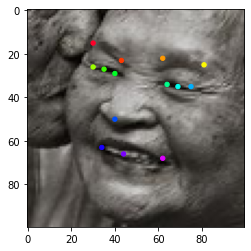

In [ ]:
filename_test = df['filename'].sample(1).values[0]
img_test, keypoints_test = read_image_and_keypoints(filename_test)
visualize_points(img_test, keypoints_test)

##Simple data augmentation
For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

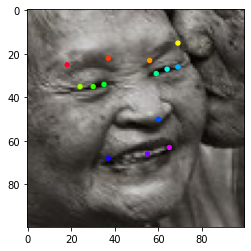

In [ ]:

import numpy as np

def flip_point(f_points, points, nb_1, nb_2 ):
    x_1 = nb_1*2
    y_1 = nb_1*2+1
    x_2 = nb_2*2
    y_2 = nb_2*2+1
    
    # Flipping is easy, because the X axis is centered at the middle of the image: we just have to put a negative sign
    f_points[x_1]=-points[x_2]
    f_points[y_1]=points[y_2]
    f_points[x_2]=-points[x_1]
    f_points[y_2]=points[y_1]

def flip_img(img, points):
    # Write your code for flipping here
    f_img = np.fliplr(img)
    
    # For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates 
    # and swap corresponding points on the left and right sides of the face)
    # When you flip the image you have to swap the following points (indexed from 1 to 14)
    # 1,4 | 2,3 | 5,10 | 6,9 | 7,8 | 11,11 | 12,14 | 13,13
    f_points = np.copy(points)
    flip_point(f_points, points, 0, 3)
    flip_point(f_points, points, 1, 2)
    flip_point(f_points, points, 4, 9)
    flip_point(f_points, points, 5, 8)
    flip_point(f_points, points, 6, 7)
    flip_point(f_points, points, 10, 10)
    flip_point(f_points, points, 11, 13)
    flip_point(f_points, points, 12, 12)
    
    return (f_img, f_points)
    #pass

f_img, f_points = flip_img(img_test, keypoints_test)
visualize_points(f_img, f_points)

##Split the data in training set and test set

In [ ]:

from sklearn.model_selection import train_test_split

tr_files, te_files = train_test_split(df['filename'], test_size=0.1)

##Solve a problem of memory
If we try to store all the images and keypoints in memory, we will get an OutOfMemory error.
Therefore, we program a generator that Keras will use in order to iterate over the dataset.

In [ ]:
from itertools import chain
from itertools import islice

# batch generator
BATCH_SIZE = 32
#BATCH_SIZE = 16

def batch_generator(filenames, batch_size):
    """
    Implement batch generator that yields items in batches of size batch_size.
    There's no need to shuffle input items, just chop them into batches.
    Remember about the last batch that can be smaller than batch_size!
    Input: any iterable (list, generator, ...). You should do `for item in items: ...`
        In case of generator you can pass through your items only once!
    Output: In output yield each batch as a list of items.
    """
    
    ### YOUR CODE HERE
    # https://stackoverflow.com/questions/24527006/split-a-generator-into-chunks-without-pre-walking-it
    iterator = iter(filenames)
    for first in iterator:        
        yield list(chain([first], islice(iterator, batch_size - 1)))

In [ ]:
import random

In [ ]:
for batch in batch_generator(tr_files, BATCH_SIZE):
    # prepare batch images
    batch_imgs = []
    batch_targets = []
    for filename in batch:
        img, keypoints = read_image_and_keypoints(filename)
        if random.randint(0,9) < 5:
          img, keypoints = flip_img(img, keypoints)
        batch_imgs.append(img)
        batch_targets.append(keypoints)
    # stack images into 4D tensor [batch_size, img_size, img_size, 3]
    batch_imgs = np.stack(batch_imgs, axis=0)
    # convert targets into 2D tensor [batch_size, num_classes]
    batch_targets = np.stack(batch_targets, axis=0)
    #print(" keypoint :", keypoint)
    #print(" img  :", keypoint)
    #print("batch img", batch_imgs)
    #print("batch img type ", batch_imgs.shape)
    #print(" batch target :",batch_targets)
    #print(" a ",batch_targets.dtype)

In [ ]:
import numpy as np
import random

def train_generator(files):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(files, BATCH_SIZE):
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for filename in batch:
                img, keypoints = read_image_and_keypoints(filename)
                if random.randint(0,9) < 5:
                  img, keypoints = flip_img(img, keypoints)
                batch_imgs.append(img)
                batch_targets.append(keypoints)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = np.stack(batch_targets, axis=0)
            print(" a ",batch_targets.dtype)
            yield batch_imgs, batch_targets

In [ ]:
train_generator(tr_files)

In [ ]:
# test training generator
for imgs, keypoints in train_generator(tr_files):
    for img, keypoint in zip(imgs, keypoints):
      visualize_points(img, keypoint)
    break

##Network architecture

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [ ]:

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, LeakyReLU, Dropout

# See https://fairyonice.github.io/Achieving-top-5-in-Kaggles-facial-keypoints-detection-using-FCN.html
# And https://fairyonice.github.io/achieving-top-23-in-kaggles-facial-keypoints-detection-with-keras-tensorflow.html
model = keras.models.Sequential()
# Define here your model

model.add(Conv2D(filters=32, kernel_size=3, padding="same", input_shape=(100, 100, 3), activation='relu'))  # first layer needs to define "input_shape"
#model.add(LeakyReLU(0.1))
model.add(MaxPooling2D(pool_size = (2,2)))    
model.add(Conv2D(filters=64, kernel_size=2, padding="same", activation='relu'))
#model.add(LeakyReLU(0.1))
model.add(MaxPooling2D(pool_size = (2,2)))    
model.add(Conv2D(filters=128, kernel_size=2, padding="same", activation='relu'))
#model.add(LeakyReLU(0.1))
model.add(MaxPooling2D(pool_size = (2,2)))
    
model.add(Flatten())
model.add(Dense(500, activation='relu'))
#model.add(LeakyReLU(0.1))
model.add(Dropout(0.25))
model.add(Dense(500, activation='relu'))
#model.add(LeakyReLU(0.1))
model.add(Dropout(0.25))
model.add(Dense(28))  
    

##Network training
Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [ ]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras import backend

def r2_keras(y_true, y_pred):
    ss_res = backend.sum(backend.square(y_true - y_pred))
    ss_tot = backend.sum(backend.square(y_true - backend.mean(y_true)))
    return ( 1 - ss_res / (ss_tot + backend.epsilon()))

model.compile(
    loss='mean_squared_error',
    optimizer=Adam(),
    metrics=[r2_keras]  # report r2 during training 
    # - commented for saving the model (otherwise load raises an error: "ValueError: Unknown metric function:r2_keras")
)


In [ ]:

# Choose optimizer, compile model and run training
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')

model.fit_generator(
    train_generator(tr_files), 
    steps_per_epoch=len(tr_files) * 2 // BATCH_SIZE // 8,
    epochs=2 * 8,
    validation_data=train_generator(te_files), 
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    callbacks=[earlyStopping],
    verbose=1,
    shuffle=True
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/16
 4/42 [=>............................] - ETA: 55s - loss: 0.2348 - r2_keras: -5.2704 

KeyboardInterrupt: ignored

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [ ]:
filenames = te_files.sample(10).values
# Example of output, for 10 files chosen randomly in the test set
img_test = np.array([read_image_and_keypoints(filename)[0] for filename in filenames])

#img_test = imgs_val[np.random.randint(imgs_val.shape[0], size=10), ...]
y_pred_test = model.predict(img_test)
for img, pred in zip(img_test, y_pred_test):
    visualize_points(img, pred)